# Product Recommendation for NFT eCommerce using Amazon Personalize

This is a PoC demo to give an overview how to collect data, train and get product recommendation from Amazon Personalize.
The PoC includes:
1. How to create product recommendation with Amazon Personalize \[Collect, Train\]
2. Evaluate the result with offline metric and backtesting \[Evaluate\]
3. Using AWS SDK to retrieve recommendation for a user combined with item metadata \[Inference\]

Remarks:
- It is a demo to show the fundamental features and help you get started.
- The result is derived from sample user-item interaction data which is for reference only.
- Demo is built programmatically by using AWS SDK in Sagemaker Notebook. However, the same can also be implemented via AWS Management Console.

Steps in this notebook:
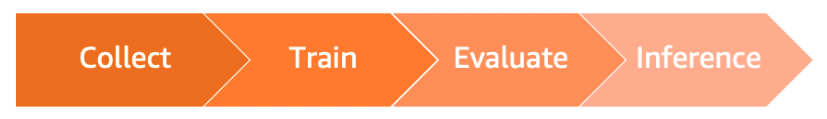


In [1]:
# upgrade pip env
!pip install --upgrade pip botocore boto3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
# import lib
import time
from time import sleep
import json
from datetime import datetime
import boto3
import pandas as pd

import sqlalchemy

from tqdm.notebook import tqdm as tqdm
import numpy as np

from metrics import mean_reciprocal_rank, ndcg_at_k, precision_at_k

# 1. Collect

## 1.1 Download and Prepare Dataset
Here I use a sqlite file to simulate NFT Mall Transcation database. 
SQLite file comes from The Moonstream NFTs dataset (https://github.com/bugout-dev/moonstream/blob/main/datasets/nfts/papers/ethereum-nfts.pdf)

Data source copyright @ https://www.kaggle.com/datasets/simiotic/ethereum-nfts

> This dataset represents the activity of the Ethereum non-fungible token (NFT) market between the following dates:
>
> - Start date: April 1, 2021
> - End date: September 25, 2021
> These data were collected using Moonstream.to as part of Moonstream's open data efforts.
>
> The dataset is based on on-chain NFT Transfer events as its core. We have also created several derived tables which make the data convenient to analyze.


In [3]:
# download nfts.sqlite.zip from S3 
data_dir = "nft-data"
!mkdir -p $data_dir

!cd $data_dir && aws s3 cp s3://personalize-nftmall-data/nfts.sqlite.zip .
!cd $data_dir && unzip nfts.sqlite.zip
dataset_dir = data_dir
!ls $dataset_dir
nft_sqlite = dataset_dir + '/nfts.sqlite'

download: s3://personalize-nftmall-data/nfts.sqlite.zip to ./nfts.sqlite.zip
Archive:  nfts.sqlite.zip
  inflating: nfts.sqlite             
nfts.sqlite  nfts.sqlite.zip


In [4]:
# try to connect with the sqlite database. In production, it may be a MySQL database
dbEngine=sqlalchemy.create_engine('sqlite:///'+dataset_dir+'/nfts.sqlite') # ensure this is the correct path for the sqlite file. 
print('Available database tables:')
display(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", dbEngine).values)

Available database tables:


array([['nfts'],
       ['checkpoint'],
       ['mints'],
       ['transfers'],
       ['transfer_values_quartile_10_distribution_per_address'],
       ['current_owners'],
       ['current_market_values'],
       ['market_values_distribution'],
       ['transfer_statistics_by_address'],
       ['transfer_values_quantile_10_distribution_per_address'],
       ['transfer_values_quantile_25_distribution_per_address'],
       ['transfers_mints'],
       ['mint_holding_times'],
       ['transfer_holding_times'],
       ['ownership_transitions']], dtype=object)

In this demo, `transfers` table will be used as the Amazon Personalize data source. Transfers included NFT transfer between owners 

Dataframe: transfers

All token transfer events crawled in this dataset.

Columns:
1. event_id: A unique event ID associated with the event.
2. transaction_hash: The hash of the transaction which triggered the event.
3. block_number: The transaction block in which the transaction was mined.
4. nft_address: The address of the NFT collection containing the transferred token.
5. token_id: The ID of the token that was transferred.
6. from_address: The "from" address for the transfer event. This is the address that owned the token at the *start* of the transfer.
7. to_address: The "to" address for the transfer event. This is the address that owned the token at the *end* of the transfer.
8. transaction_value: The amount of WEI that were sent with the transaction in which the token was transferred.
9. timestamp: The time at which the transfer operation was mined into the blockchain (this is the timestamp for the mined block).


In [5]:
transfers_df = pd.read_sql('select * from transfers',dbEngine)
print(transfers_df.info())
display(transfers_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514729 entries, 0 to 4514728
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   event_id           object 
 1   transaction_hash   object 
 2   block_number       int64  
 3   nft_address        object 
 4   token_id           object 
 5   from_address       object 
 6   to_address         object 
 7   transaction_value  float64
 8   timestamp          int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 310.0+ MB
None


,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp
0,cd816651-56b2-4ed9-887c-c83de732428d,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,6682934142305278177002530107138320246486863356...,0x25f1d709b329C7349b8209851E90eFa3a7f60178,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481
1,82cc5228-eb80-4e0d-9f6f-e644dec3ab06,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1198507443711741845273832738859307575893198744...,0x0737E7162C88E9FBB963334e4Bfe6e97447fF811,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481
2,6e1f9cc4-d1df-4a6b-972d-a20765beb326,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1541220344281436903042142177888467401468454835...,0xA0fEc186c4b3FAd39ca373dFdd52E79C2495F2c3,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481
3,43dc27a7-a72d-4894-809c-e868de05f7ee,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,7993840355029527745913866651030234226423689128...,0x90bE22069560A9bAd99543B4A922d1FE34Ae84E9,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481
4,47b7839b-9b87-442d-b2c1-9ebedcad8e06,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1123719749142984581497870712442861055686734521...,0xA8E9C42Ebb915EeEC5080B7Bcc5D844475595091,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481


## 1.2 Prepare dataset
Amazon Personalize datasets are containers for data. A dataset group is a collection of related datasets (Interactions, Users, and Items). There are three types of datasets in Amazon Personalize:

- Interactions: This dataset stores historical and real-time data from interactions between users and items. This data can include impressions data and contextual metadata on your users’ browsing context, such as their location or device (mobile, tablet, desktop, and so on). You must at minimum create an Interactions dataset.
- Users: This dataset stores metadata about your users. This might include information such as age, gender, or loyalty membership which can be important in personalization systems.
- Items: This dataset stores metadata about your items. This might include information such as price, SKU type, or availability.



In this step, we will transform the 100K rows of `transfers` dataframe into Interaction Dataset only. 
For the advanced use of other types of datasets, see Datasets and Schemas. (https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html)

Two Event types are defined. 
- `Purchase` means the transfer including positive transaction_value; where 
- `Free` means the transfer is just a free transfer.

Then, combining them together as the `interaction` with expected schema.


In [6]:
purchased_df = transfers_df.copy()
purchased_df = purchased_df[purchased_df['transaction_value'] > 0]
purchased_df = purchased_df[['to_address','token_id', 'nft_address', 'timestamp', 'transaction_value', 'from_address']]
purchased_df['EVENT_TYPE'] = 'Purchase'
# display(purchased_df)

free_df = transfers_df.copy()
free_df = free_df[free_df['transaction_value'] == 0]
free_df = free_df[['to_address','token_id', 'nft_address', 'timestamp', 'transaction_value', 'from_address']]
free_df['EVENT_TYPE'] = 'Free'

interactions_df = pd.concat([purchased_df, free_df])
interactions_df.sort_values("timestamp", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')

In [7]:
# rename columns and save as csv file locally
interactions_df.rename(columns = {'to_address':'USER_ID', 'token_id':'TOKEN_ID', 
                              'timestamp':'TIMESTAMP', 'nft_address': 'ITEM_ID',
                              'transaction_value': 'PRICE',
                              'from_address': 'OWNER_USER_ID'}, inplace = True) 

interactions_df = interactions_df[['USER_ID', 'ITEM_ID', 'EVENT_TYPE', 'TIMESTAMP', 'TOKEN_ID',
                                  'OWNER_USER_ID','PRICE']]


In [8]:
#remove Null address in chain

# null address
interactions_df = interactions_df[interactions_df['USER_ID'] !='0x0000000000000000000000000000000000000000'] 

# stablecoin address
interactions_df = interactions_df[interactions_df['USER_ID'] !='0x0000000000000000000000000000000000000001'] 

In [9]:
# take sample 100000 rows for demo purpose
interactions_df = interactions_df.head(100000)

In [11]:
print('unique users %d; unique items %d'%(
    len(interactions_df['USER_ID'].unique()), len(interactions_df['ITEM_ID'].unique())))


display(interactions_df)
print(interactions_df.info())

unique users 23225; unique items 1037


,USER_ID,ITEM_ID,EVENT_TYPE,TIMESTAMP,TOKEN_ID,OWNER_USER_ID,PRICE
3940485,0x8072566Fcdbe9E1827C57A8091085a3095bd4cF0,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,Purchase,1617235214,2067216718446828862151509780737619171783478638...,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,5.749535e+15
3940484,0x9FF5ad420c4DAf1eeA5331081b5b5c07EF12D82C,0xF6C71e1e72254051F2e26270C16A84Fbd1dBFAfD,Free,1617235235,50,0xBb3f083C03bf3a9C6e807487F441d0680f7B6c81,0.000000e+00
3940486,0xa1D3F6BF7dE7f968789e2C9F3CFDdD49cb01a30c,0x60F80121C31A0d46B5279700f9DF786054aa5eE5,Free,1617235235,696112,0x1816359F9af8a725160BD51e2a25b1fbE6d5bB74,0.000000e+00
3940487,0xa353401738e7ec6A4db9C0ee4C66eB5252f681C4,0xb932a70A57673d89f4acfFBE830E8ed7f75Fb9e0,Free,1617235235,16412,0x9f37284b3a538BE8EEa2d401B595f44C96D39B70,0.000000e+00
3940488,0xB146CaD3eF5F6D929629A28ff432628E6Faf995C,0x60F80121C31A0d46B5279700f9DF786054aa5eE5,Free,1617235260,696111,0x1816359F9af8a725160BD51e2a25b1fbE6d5bB74,0.000000e+00
...,...,...,...,...,...,...,...
4043454,0xCEd22A7652B0394a24b15663370eF3c4171dd17E,0xDC76a2DE1861Ea49E8b41A1De1E461085E8F369F,Free,1618369026,1059,0x96bEE49d3386d674bF4E956D9B3ce61b9540409D,0.000000e+00
4043481,0xcDA72070E455bb31C7690a170224Ce43623d0B6f,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,Free,1618369030,24060,0x8c5461D9b6992D12FAd3Ae70943066BD32f9A86C,0.000000e+00
4043441,0x2075e5ED7702Dd03cf7cFE06C45277c89817b189,0xa7d8d9ef8D8Ce8992Df33D8b8CF4Aebabd5bD270,Purchase,1618369095,39000670,0x8B970308e8935bd874166c7a252BB8F4c39b03B5,1.300000e+17
4043429,0x6d88Ee8CD533b18BCcf7668c9712B55190f01ce8,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,Free,1618369100,8102007582718626618675261328618375129452232926...,0x327305A797d92a39cEe1a225D7E2A1cC42B1a8fA,0.000000e+00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3940485 to 4043431
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   USER_ID        100000 non-null  object 
 1   ITEM_ID        100000 non-null  object 
 2   EVENT_TYPE     100000 non-null  object 
 3   TIMESTAMP      100000 non-null  int64  
 4   TOKEN_ID       100000 non-null  object 
 5   OWNER_USER_ID  100000 non-null  object 
 6   PRICE          100000 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 6.1+ MB
None


### Extract 10% as holdout dataset for backtesting

We extract last 10% interactions for each user_id as holdout dataset

In [12]:
#split 90% train, 10% holdout
data = interactions_df.copy()
ranks = data.groupby('USER_ID').TIMESTAMP.rank(pct=True, method='first')
data = data.join((ranks>0.9).to_frame('holdout'))
holdout = data[data['holdout']].drop('holdout', axis=1)
data = data[~data['holdout']].drop('holdout', axis=1)
interactions_df_train = data.copy()
interactions_df_test = holdout.copy()

print('Total rows = %d'%(len(interactions_df)))
print('Training set rows = %d'%(len(interactions_df_train)))
print('Holdout test set rows = %d'%(len(interactions_df_test)))

Total rows = 100000
Training set rows = 72460
Holdout test set rows = 27540


In [13]:
print('unique users %d; unique items %d'%(
    len(data['USER_ID'].unique()), len(data['ITEM_ID'].unique())))
data

unique users 11077; unique items 813


,USER_ID,ITEM_ID,EVENT_TYPE,TIMESTAMP,TOKEN_ID,OWNER_USER_ID,PRICE
3940485,0x8072566Fcdbe9E1827C57A8091085a3095bd4cF0,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,Purchase,1617235214,2067216718446828862151509780737619171783478638...,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,5.749535e+15
3940484,0x9FF5ad420c4DAf1eeA5331081b5b5c07EF12D82C,0xF6C71e1e72254051F2e26270C16A84Fbd1dBFAfD,Free,1617235235,50,0xBb3f083C03bf3a9C6e807487F441d0680f7B6c81,0.000000e+00
3940487,0xa353401738e7ec6A4db9C0ee4C66eB5252f681C4,0xb932a70A57673d89f4acfFBE830E8ed7f75Fb9e0,Free,1617235235,16412,0x9f37284b3a538BE8EEa2d401B595f44C96D39B70,0.000000e+00
3940478,0x42F7c5275aC4372156027d939843C9C42523DF2E,0x85F0e02cb992aa1F9F47112F815F519EF1A59E2D,Purchase,1617235482,1000002086,0x366E99753E62D9BeAb40537cC9B2beCDBD9105C0,1.000000e+17
3940479,0x42F7c5275aC4372156027d939843C9C42523DF2E,0x85F0e02cb992aa1F9F47112F815F519EF1A59E2D,Purchase,1617235482,1000002868,0xdA9890CbC6982950508Aa947C196f3A93636E47C,3.900000e+17
...,...,...,...,...,...,...,...
4043446,0x3634331F1B29fE45d7389F503be42e30D5fE44CB,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,Free,1618368545,1139505565639961183607525090821631806388007918...,0x327305A797d92a39cEe1a225D7E2A1cC42B1a8fA,0.000000e+00
4043447,0x3634331F1B29fE45d7389F503be42e30D5fE44CB,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,Free,1618368545,6731972920543378254296027526307633432345560307...,0x327305A797d92a39cEe1a225D7E2A1cC42B1a8fA,0.000000e+00
4043448,0xaca9fBac4f5C030b02F4D6fa926992C9cbd781Fe,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,Free,1618368545,8961968398500178366848052000056830113979587629...,0x23c3a944c2c9d60ac854FB391F10984A0F61ECE5,0.000000e+00
4043450,0x23c3a944c2c9d60ac854FB391F10984A0F61ECE5,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,Free,1618368545,6373434260125152333607615761504462618954833809...,0xaca9fBac4f5C030b02F4D6fa926992C9cbd781Fe,0.000000e+00


In [14]:
interactions_filename = "interaction_collection_df.csv"
interactions_df_train.to_csv((data_dir+"/"+interactions_filename), index=False, float_format='%.0f')

interactions_filename_test = "interaction_collection_df_test.csv"
interactions_df_test.to_csv((data_dir+"/"+interactions_filename_test), index=False, float_format='%.0f')

## 1.3 Import data into Amazon Personalize

### First define the Amazon Personalize dataset group name 
Example = nftmall-poc-`random string`

In [34]:
import random
import string

def get_random_string(length):
    # With combination of lower and upper case
    result_str = ''.join(random.choice(string.ascii_letters) for i in range(length))
    return result_str.lower()

try: dataset_group_name
except NameError: dataset_group_name = None

if dataset_group_name is None:
    dataset_group_name = 'nftmall-poc-' + get_random_string(4)
print('dataset_group_name = ' + dataset_group_name)

dataset_group_name = nftmall-poc-lwaa


### S3 bucket and IAM setup

We create an Amazon S3 bucket to stage your interactions dataset. To ensure that Amazon Personalize can access and work with the data, you must also grant permissions using IAM roles and policies. 

In [35]:
# upload csv to s3 

session = boto3.session.Session()
region = session.region_name
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + dataset_group_name
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
        )

504931058669-ap-southeast-1-nftmall-poc-lwaa


In [36]:
interactions_file_path = data_dir + "/" + interactions_filename
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+interactions_filename

In [37]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': 'RTTQSADF93PHPMBR',
  'HostId': 'Ien3GG3qYH+cUfTkxmBPE2le2kXicwIqwz5ELirSW7DALMr7P3/ZP1Zn4aXugGwMYrMFsPrh+YA=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'Ien3GG3qYH+cUfTkxmBPE2le2kXicwIqwz5ELirSW7DALMr7P3/ZP1Zn4aXugGwMYrMFsPrh+YA=',
   'x-amz-request-id': 'RTTQSADF93PHPMBR',
   'date': 'Sun, 20 Nov 2022 15:17:53 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [38]:
iam = boto3.client("iam")

role_name = dataset_group_name + "PersonalizeRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)


arn:aws:iam::504931058669:role/nftmall-poc-lwaaPersonalizeRole


### Import Data into Amazon Personalize Dataset 
1. Create Dataset group
2. Define Schema
3. Create Dataset (INTERACTIONS, USERS, ITEMS)
4. Import data

#### Create Dataset group
A dataset group is a collection of related datasets. For this step, you create a ECommerce Domain Managed Dataset group and then activate it. 

In [40]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

In [41]:
response = personalize.create_dataset_group(
    name=dataset_group_name,
    domain='ECOMMERCE'
)

dataset_group_arn = response['datasetGroupArn']
print(json.dumps(response, indent=2))


{
  "datasetGroupArn": "arn:aws:personalize:ap-southeast-1:504931058669:dataset-group/nftmall-poc-lwaa",
  "domain": "ECOMMERCE",
  "ResponseMetadata": {
    "RequestId": "1bd2866d-3adb-418f-af55-6012ff745003",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sun, 20 Nov 2022 15:19:52 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "121",
      "connection": "keep-alive",
      "x-amzn-requestid": "1bd2866d-3adb-418f-af55-6012ff745003"
    },
    "RetryAttempts": 0
  }
}


In [42]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(30)



DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE
CPU times: user 7.18 ms, sys: 976 µs, total: 8.15 ms
Wall time: 30.1 s


#### Define Schema
Amazon Personalize needs a schema to understand your data. The following code block creates the appropriate schema for the dataset and provides it to Personalize. This code block also creates the interactions dataset within the dataset group. Personalize uses this dataset to train the recommendation model. 
In this demo, we only create `INTERACTIONS` schema

In [43]:
interactions_schema = schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "TOKEN_ID",
            "type": "string"
        },
        {
            "name": "OWNER_USER_ID",
            "type": "string"
        },
        {
            "name": "PRICE",
            "type": "float"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = dataset_group_name + "-int-schema",
    domain = "ECOMMERCE",
    schema = json.dumps(interactions_schema)
)

interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-southeast-1:504931058669:schema/nftmall-poc-lwaa-int-schema",
  "ResponseMetadata": {
    "RequestId": "b6c47e92-c81e-4d9e-99b2-61665adc77db",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sun, 20 Nov 2022 15:20:24 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "98",
      "connection": "keep-alive",
      "x-amzn-requestid": "b6c47e92-c81e-4d9e-99b2-61665adc77db"
    },
    "RetryAttempts": 0
  }
}


In [44]:
dataset_type = "INTERACTIONS"

create_dataset_response = personalize.create_dataset(
    name = dataset_group_name + '_ds',
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))



{
  "datasetArn": "arn:aws:personalize:ap-southeast-1:504931058669:dataset/nftmall-poc-lwaa/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "da3c855d-5990-44f4-be5d-cbcf7afb3c3c",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sun, 20 Nov 2022 15:20:29 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "102",
      "connection": "keep-alive",
      "x-amzn-requestid": "da3c855d-5990-44f4-be5d-cbcf7afb3c3c"
    },
    "RetryAttempts": 0
  }
}


#### Import data

Create Dataset import job with S3 data source. This can also be 

In [45]:

create_interactions_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = dataset_group_name + "_interactions_import",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)

dataset_interactions_import_job_arn = create_interactions_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_interactions_dataset_import_job_response, indent=2))



{
  "datasetImportJobArn": "arn:aws:personalize:ap-southeast-1:504931058669:dataset-import-job/nftmall-poc-lwaa_interactions_import",
  "ResponseMetadata": {
    "RequestId": "db7d20f4-4260-4dc8-94d6-d4c56f11e8a1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sun, 20 Nov 2022 15:20:34 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "129",
      "connection": "keep-alive",
      "x-amzn-requestid": "db7d20f4-4260-4dc8-94d6-d4c56f11e8a1"
    },
    "RetryAttempts": 0
  }
}


In [46]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_interactions_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)



DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE
CPU times: user 45.4 ms, sys: 8.04 ms, total: 53.5 ms
Wall time: 4min


# 2. Train

## 2.1 Train Recommendation Models

Amazon Personalize has recipes for different scenarios. 
In this demo, we will use ECommerce Domain Recommender `Recommended For You` as the Production recommendation PoC.
Also, a custom solution `Popularity Count` is used as the baseline for perfomrance evaluation.

In [47]:
recipe_list = personalize.list_recipes()
for recipe in recipe_list['recipes']:
    print(recipe['recipeArn'])

arn:aws:personalize:::recipe/aws-ecomm-customers-who-viewed-x-also-viewed
arn:aws:personalize:::recipe/aws-ecomm-frequently-bought-together
arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-purchases
arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-views
arn:aws:personalize:::recipe/aws-ecomm-recommended-for-you
arn:aws:personalize:::recipe/aws-item-affinity
arn:aws:personalize:::recipe/aws-item-attribute-affinity
arn:aws:personalize:::recipe/aws-personalized-ranking
arn:aws:personalize:::recipe/aws-popularity-count
arn:aws:personalize:::recipe/aws-similar-items
arn:aws:personalize:::recipe/aws-sims


### Create ECommerce Domain Recommender - Recommended For you

In [48]:
create_recommender_response = personalize.create_recommender(
  name = dataset_group_name+'recommended_for_you',
  recipeArn = 'arn:aws:personalize:::recipe/aws-ecomm-recommended-for-you',
  datasetGroupArn = dataset_group_arn
)
recommended_for_you_arn = create_recommender_response["recommenderArn"]
print (json.dumps(create_recommender_response))



{"recommenderArn": "arn:aws:personalize:ap-southeast-1:504931058669:recommender/nftmall-poc-lwaarecommended_for_you", "ResponseMetadata": {"RequestId": "fc63006a-25cc-45cb-b2cb-b2a760c71663", "HTTPStatusCode": 200, "HTTPHeaders": {"date": "Sun, 20 Nov 2022 15:26:18 GMT", "content-type": "application/x-amz-json-1.1", "content-length": "116", "connection": "keep-alive", "x-amzn-requestid": "fc63006a-25cc-45cb-b2cb-b2a760c71663"}, "RetryAttempts": 0}}


### Create baseline solution - Popularity Count

In [49]:
baseline_recipe_arn = 'arn:aws:personalize:::recipe/aws-popularity-count'

In [50]:
create_solution_response = personalize.create_solution(
    name = dataset_group_name + "_popularity",
    datasetGroupArn = dataset_group_arn,
    recipeArn = baseline_recipe_arn,
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:ap-southeast-1:504931058669:solution/nftmall-poc-lwaa_popularity",
  "ResponseMetadata": {
    "RequestId": "1e74dcc7-dd19-42b7-82b8-10ecbfe37a69",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sun, 20 Nov 2022 15:26:31 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "102",
      "connection": "keep-alive",
      "x-amzn-requestid": "1e74dcc7-dd19-42b7-82b8-10ecbfe37a69"
    },
    "RetryAttempts": 0
  }
}


In [51]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:504931058669:solution/nftmall-poc-lwaa_popularity/00409b6f",
  "ResponseMetadata": {
    "RequestId": "f3f91b59-d3f6-4522-b8a4-d345a690557f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sun, 20 Nov 2022 15:26:38 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "118",
      "connection": "keep-alive",
      "x-amzn-requestid": "f3f91b59-d3f6-4522-b8a4-d345a690557f"
    },
    "RetryAttempts": 0
  }
}


### Wait for Solution Version to Have ACTIVE Status

In [52]:
%%time

max_time = time.time() + 10*60*60 # 10 hours
    
while time.time() < max_time:

    version_response = personalize.describe_recommender(
        recommenderArn = recommended_for_you_arn
    )
    status = version_response["recommender"]["status"]

    if status == "ACTIVE":
        print("Build succeeded for {}".format(recommended_for_you_arn))
        
    elif status == "CREATE FAILED":
        print("Build failed for {}".format(recommended_for_you_arn))
        break

    if status == "ACTIVE" or status == "CREATE FAILED":
        break
    else:
        print('The "Recommended for you" Recommender build is still in progress')
        
    time.sleep(60)
    

The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you" Recommender build is still in progress
The "Recommended for you"

In [53]:
%%time
max_time = time.time() + 10*60*60 # 10 hours
    
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break

SolutionVersion: ACTIVE
CPU times: user 719 µs, sys: 3.82 ms, total: 4.54 ms
Wall time: 34.8 ms


# 3. Evaluate

## 3.1 Evalute the model performance with Metrics

You can evaluate the performance of your recommender through offline and online metrics. 
- `Online metrics` are the empirical results you observe in your users' interactions with real-time recommendations. 
- `Offline metrics` are the metrics that Amazon Personalize generates when you create a recommender. You can use offline metrics to evaluate the performance of the recommender's underlying model. Offline metrics allow you to compare the model with other models trained on the same data. For the rest of this section, the term metrics refers to offline metrics.

Offline metrics includes:

|Name	|<div style="width:290px">Example</div>	|Explanation
|:------|:----------|:----------
|Coverage   | `count(recommended item)`/`count(items)`   | The proportion of unique items that Amazon Personalize might recommend out.
|Precision@K	|$\frac{2}{4} = 0.5$	|Total relevant items divided by total recommended items.
|Mean reciprocal ranks (MRR@K)	|${\rm mean}(\frac{1}{2} + \frac{1}{4}) = 0.375$	|Ability to generate a relevant recommendation at the top ranked position
|Normalized discounted cumulative gains (NDCG@K)	|$\frac{\frac{1}{\log(1 + 2)} + \frac{1}{\log(1 + 4)}}{\frac{1}{\log(1 + 1)} + \frac{1}{\log(1 + 2)}} = 0.65$	|How well your model ranks recommendations, where K is a sample size of 5, 10, or 25 recommendations

### Metrics from AWS Console
Below Metrics can be found in the AWS management console. They can also received by AWS CLI and SDK. https://docs.aws.amazon.com/personalize/latest/dg/evaluating-recommenders.html#retrieving-recommender-metrics



eCommerce - Recommended For You metric:
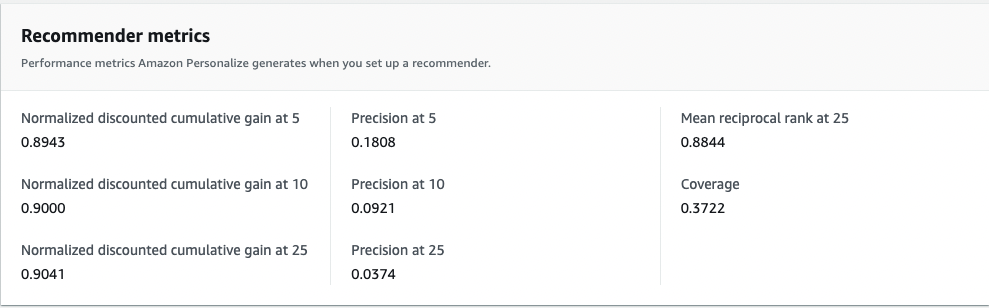

Baseline (Popularity Count) metric:
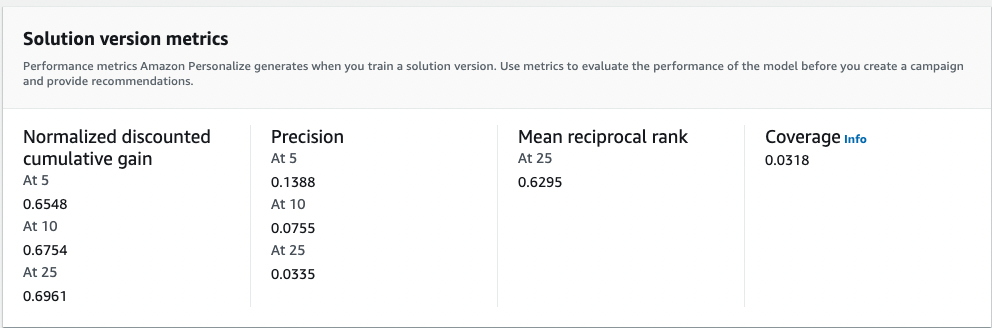

### Metrics from SDK

In [68]:
# baseline metrics
get_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)
print('=== Baseline (Popularity Count) metrics')
print(json.dumps(get_metrics_response['metrics'], indent=2))
baseline_metric = get_metrics_response['metrics']

=== Baseline (Popularity Count) metrics
{
  "coverage": 0.0318,
  "mean_reciprocal_rank_at_25": 0.6295,
  "normalized_discounted_cumulative_gain_at_10": 0.6754,
  "normalized_discounted_cumulative_gain_at_25": 0.6961,
  "normalized_discounted_cumulative_gain_at_5": 0.6548,
  "precision_at_10": 0.0755,
  "precision_at_25": 0.0335,
  "precision_at_5": 0.1388
}


In [69]:
# Recommender metrics
response = personalize.describe_recommender(
    recommenderArn = recommended_for_you_arn
)

print(json.dumps(response['recommender']['modelMetrics'], indent=2))
ecomm_recommended_for_you_metric = response['recommender']['modelMetrics']

{
  "coverage": 0.3722,
  "mean_reciprocal_rank_at_25": 0.8844,
  "normalized_discounted_cumulative_gain_at_10": 0.9,
  "normalized_discounted_cumulative_gain_at_25": 0.9041,
  "normalized_discounted_cumulative_gain_at_5": 0.8943,
  "precision_at_10": 0.0921,
  "precision_at_25": 0.0374,
  "precision_at_5": 0.1808
}


## 3.2 Backtesting with Holdout dataset

Although the offline metric shows the performance of the result, data scientist usually want to do a backtesting to further evaluate the model with a complete seperate dataset from the training data (i.e. Holdout test dataset).

Below will loop each `USER_ID` and inference the model for recommendation list via Amazon Personalize SDK. Then do an external evalution here.

### Evaluate using external metrics

The calculations are the same as in offline metrics.
An explanation of the evaluation metrics are provided at https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html

In [58]:
%%time
relevance = []
for user_id, true_items in tqdm(interactions_df_test.groupby('USER_ID').ITEM_ID):
    get_recommendations_response = personalize_runtime.get_recommendations(
        recommenderArn = recommended_for_you_arn,
        userId = str(user_id),
        numResults = 25
    )
    rec_items = [str(x['itemId']) for x in get_recommendations_response['itemList']]
    relevance.append([int(x in true_items.values) for x in rec_items])

  0%|          | 0/23225 [00:00<?, ?it/s]

CPU times: user 39 s, sys: 2.2 s, total: 41.2 s
Wall time: 12min 39s


In [84]:
holdout_metric = {
  "coverage": '',
  "mean_reciprocal_rank_at_25": np.mean([mean_reciprocal_rank(r) for r in relevance]),
  "normalized_discounted_cumulative_gain_at_10": np.mean([ndcg_at_k(r, 10) for r in relevance]),
  "normalized_discounted_cumulative_gain_at_25": np.mean([ndcg_at_k(r, 25) for r in relevance]),
  "normalized_discounted_cumulative_gain_at_5": np.mean([ndcg_at_k(r, 5) for r in relevance]),
  "precision_at_10": np.mean([precision_at_k(r, 10) for r in relevance]),
  "precision_at_25": np.mean([precision_at_k(r, 20) for r in relevance]),
  "precision_at_5": np.mean([precision_at_k(r, 5) for r in relevance])
}

print(json.dumps(holdout_metric, indent=2))

{
  "coverage": "",
  "mean_reciprocal_rank_at_25": 0.4106928229294849,
  "normalized_discounted_cumulative_gain_at_10": 0.4542136838317478,
  "normalized_discounted_cumulative_gain_at_25": 0.4871688588470375,
  "normalized_discounted_cumulative_gain_at_5": 0.4424968029581597,
  "precision_at_10": 0.05241765339074273,
  "precision_at_25": 0.03171582346609257,
  "precision_at_5": 0.09780839612486544
}


## 3.3 Evaluate Findings

In the internal `Offline metric`, eCommerce `Recommended For You` model is better than the baseline (Popularity Count). The scores showed the recommendation can rank relevent items in a higher position, but overall precision is relatively low. Since the demo dataset only involve `Transfer` data, it did not show the real user behavior. It could possibly be improved by using dataset in real scenario; 

In the `holdout backtesting`, the scores reduced. Possible reasons are listed as below:
* They are evaluated at different times, which may imply different interactions rates. We recommend to always keep the evaluations in the same time periods to avoid temporal drifts.
* The example external evaluations may hold out and consider multiple items as ground truth, while the internal evaluations only hold out the last item in each user-history as the ground truth. There is no absolute preference as to how many items should be held out; we recommend designing the evaluation methods that are similar to the actual use case.
* Possibly over-fit in the training dataset, which means the dataset did not include all user behaviors





In [86]:
print('Metrics comparison table:')
pd.DataFrame([baseline_metric, ecomm_recommended_for_you_metric, holdout_metric], 
             index=['Basline', 'EComm-Recommended_for_you', 'Holdout-test'],
             columns=['coverage', 'mean_reciprocal_rank_at_25', 
                     'normalized_discounted_cumulative_gain_at_5','normalized_discounted_cumulative_gain_at_10', 'normalized_discounted_cumulative_gain_at_25',
                     'precision_at_5', 'precision_at_10', 'precision_at_25']
            ).T

Metrics comparison table:


,Basline,EComm-Recommended_for_you,Holdout-test
coverage,0.0318,0.3722,
mean_reciprocal_rank_at_25,0.6295,0.8844,0.410693
normalized_discounted_cumulative_gain_at_5,0.6548,0.8943,0.442497
normalized_discounted_cumulative_gain_at_10,0.6754,0.9,0.454214
normalized_discounted_cumulative_gain_at_25,0.6961,0.9041,0.487169
precision_at_5,0.1388,0.1808,0.097808
precision_at_10,0.0755,0.0921,0.052418
precision_at_25,0.0335,0.0374,0.031716


# 4. Inference

## 4.1 Getting recommendations with a recommender

Now, the recommenders have been trained, lets have a look at the recommendations we can get for our users!

To give better integration, the recommendation results can be combined with nfts metadata which can be found in `nfts` dataset. 

This code could also be migrated into `AWS Lambda` to provide a product recommendation API endpoint for the webapp integration. https://docs.aws.amazon.com/apigateway/latest/developerguide/getting-started-with-lambda-integration.html

In [87]:
# get nfts metadata
nfts_df = pd.read_sql('select * from nfts',dbEngine)
print(nfts_df.info())
display(nfts_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  9388 non-null   object
 1   name     9352 non-null   object
 2   symbol   9355 non-null   object
dtypes: object(3)
memory usage: 220.2+ KB
None


,address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES


In [88]:
# define get_item_by_id function to get nft meta data 
def get_item_by_id(item_id):
    find = nfts_df[nfts_df['address'] == item_id]
    return find

In [89]:
# First pick a user
test_user_id = "0xeF7F9d712a82aE54c6Ece9d95B7E1ec7449747ed" 

In [90]:
recommended_for_you_arn

'arn:aws:personalize:ap-southeast-1:504931058669:recommender/nftmall-poc-lwaarecommended_for_you'

In [93]:
# Get recommendations for the user
get_recommendations_response = personalize_runtime.get_recommendations(
    recommenderArn = recommended_for_you_arn,
    userId = test_user_id,
    numResults = 25
)

# Build a new dataframe for the recommendations with item metadata
item_list = get_recommendations_response['itemList']
recommendation_list = []
for item in item_list:
    item_df = get_item_by_id(item['itemId'])
    recommendation_list.append({
        "item_id": item['itemId'],
        "name": item_df['name'].values[0],
        "symbol": item_df['symbol'].values[0],
    })


user_recommendations_df = pd.DataFrame(recommendation_list, columns = ['item_id', 'name', 'symbol'])


pd.options.display.max_rows =25

print("Recommended list for UserId = %s:"%(test_user_id))
display(user_recommendations_df)


Recommended list for UserId = 0xeF7F9d712a82aE54c6Ece9d95B7E1ec7449747ed:


,item_id,name,symbol
0,0x60F80121C31A0d46B5279700f9DF786054aa5eE5,Rarible,RARI
1,0x85F0e02cb992aa1F9F47112F815F519EF1A59E2D,PolkamonOfficialCollection,PMONC
2,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,None,None
3,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,CryptoKitties,CK
4,0x417cf58dC18edd17025689D13AF2b85F403E130C,Crypteriors,Crypterior
5,0xC2C747E0F7004F9E8817Db2ca4997657a7746928,Hashmasks,HM
6,0xa7d8d9ef8D8Ce8992Df33D8b8CF4Aebabd5bD270,Art Blocks,BLOCKS
7,0x0E3A2A1f2146d86A604adc220b4967A898D7Fe07,Gods Unchained Cards,CARD
8,0x50f5474724e0Ee42D9a4e711ccFB275809Fd6d4a,Sandbox's LANDs,LAND
9,0xbC17cd7f1A58bdA5d6181618090813B3050416b5,Framergence,FRAM


# 5. Clean up (Optional)

In [ ]:
# personalize.delete_recommender(recommenderArn=recommended_for_you_arn)
# while len(personalize.list_recommenders(datasetGroupArn=dataset_group_arn)['recommenders']):
#     time.sleep(5)

# personalize.delete_solution(solutionArn=solution_arn)
# while len(personalize.list_solutions(datasetGroupArn=dataset_group_arn)['solutions']):
#     time.sleep(5)

# for dataset in personalize.list_datasets(datasetGroupArn=dataset_group_arn)['datasets']:
#     personalize.delete_dataset(datasetArn=dataset['datasetArn'])
# while len(personalize.list_datasets(datasetGroupArn=dataset_group_arn)['datasets']):
#     time.sleep(5)

# personalize.delete_dataset_group(datasetGroupArn=dataset_group_arn)

### If you are using a personal bucket Execute this cell with caution!

In [ ]:
# !aws s3 rm s3://{bucket_name} --recursive